## Disaster Tweets Prediction 

### Retreiving the data

In [1]:
import pandas as pd
tweets = pd.read_csv("/Users/hinaljajal/Downloads/train.csv")

### Importing raw libraries

In [2]:
import numpy as np
import pandas as pd 
import re
import nltk
import matplotlib
import wordcloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

### Data Cleaning and Processing

In [3]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We check the data for duplicates. 

In [ ]:
#Column that creates a count of the tweets
tweets['count'] = 1
dups = tweets.groupby('text').sum()
mask = dups['count'] > 1
dups[mask]

We can see that there are 69 tweets that do have duplicates. So, first we will delete those rows which have exact duplicates (ie. all the other columns for that particular row are also the same). In this case, we delete the duplicates but keep the first instance.  

In [ ]:
tweets = tweets.drop_duplicates(keep="first")

Now, that all the exact duplicates are deleted, we check if there are any duplicates only of the "text" column and delete those completely because that would mean we have contradicting data.

In [ ]:
tweets = tweets.drop_duplicates(subset='text')

Now, we check for missing values in the data. 

In [4]:
print(tweets.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [5]:
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Only the columns "keyword" and "location" have missing values but the column "keyword" doesn't seem of any explanatory value, while the column "location" has a huge proportion of missing values. Hence, we will drop both of these columns. "id" is not of any use either, so we drop that as well. 

In [6]:
tweets = tweets.drop("keyword",axis=1)
tweets = tweets.drop("location",axis=1)
tweets = tweets.drop("id",axis=1)

By looking at the tweets, we find that there's many special characters and numbers that we don't need, so we'll get rid of those. We also convert all the words to lowercase. Then, we lemmatize the words, which will return the lemmas of the words.

In [7]:
tweets_list  = []
for i in range(tweets['text'].shape[0]):
    #Uses regular expressions to remove special characters or numbers
    tweet = re.sub("[^a-zA-Z]", ' ', tweets['text'][i])
    #Converts all words to lowercase
    tweet = tweet.lower()
    lemmer=WordNetLemmatizer()
    tweet = [lemmer.lemmatize(word) for word in tweet.split()]
    #Appends the cleaned tweet to the list of tweets
    tweet = ' '.join(tweet)
    tweets_list.append(tweet)

### Data Exploration

In [8]:
hashtags = []
#Extracting the hashtags from the tweets
for i in range(tweets['text'].shape[0]):
    s = tweets['text'][i]
    for x in s.split():
        if x.startswith("#"):
            hashtags.append(x[1:])

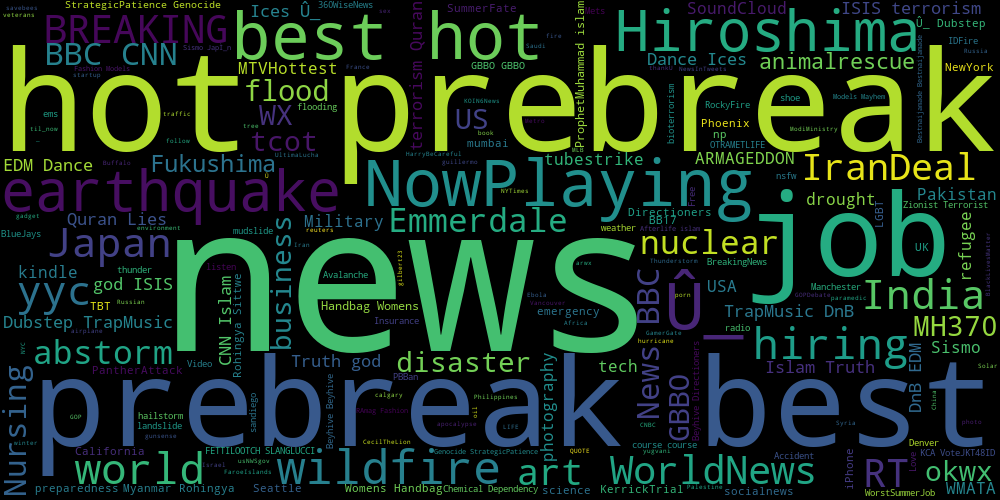

In [9]:
#Creates a word cloud of the hashtags
wc = WordCloud(width=1000, height=500).generate(" ".join(hashtags))
wc.to_image()

It's evident in the word cloud how, while many of these of tweets are about real disasters such as Hiroshima, quite a chunk of them also talk about music ("NowPlaying"). 

## Creating the model

In [26]:
#Creates a countvectorizer which will tokenize the tweets and remove English stop words  
countVec = CountVectorizer(stop_words="english")
words = countVec.fit_transform(tweets_list).toarray()

In [12]:
X = words
y = tweets['target']
#Splits the data into training and testing sets
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20)

In [13]:
#Creates a decision tree model 
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [14]:
cv = cross_val_score(tree,X_train,y_train,cv=5)

In [16]:
#Creates a support vector classifier model 
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [17]:
cv1 = cross_val_score(svc,X_train,y_train,cv=5)

In [19]:
#Creates a random forest classifier model 
rcf = RandomForestClassifier()
svc.fit(X_train,y_train)

SVC()

In [20]:
cv2 = cross_val_score(rcf,X_train,y_train,cv=5)

[Text(0.5, 0, 'Fold Number'), Text(0, 0.5, 'Cross Val Score')]

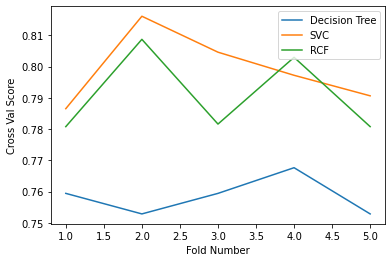

In [27]:
fig,ax=plt.subplots(1)
x = np.arange(1,6)
ax.plot(x,cv,label="Decision Tree")
ax.plot(x,cv1,label="SVC")
ax.plot(x,cv2,label="RCF")
ax.legend()
ax.set(xlabel="Fold Number",
       ylabel="Cross Val Score")

We can see that cross validation predicts that the SVC model would be most accurate in its predictions. Now, we score the SVC model on our test data. 

In [24]:
svc.score(X_test,y_test)

0.799080761654629